# MSDS 7331 - Lab 3 - Airline Satisfaction Dataset
***
Team - Triston Hudgins, Shijo Joseph, Douglas Yip

#### The dataset chosen is a compilation of airline customer satisfaction surveys.  The goal is to select from one of features (Association Rule Mining, Clustering, or Collaborative Filtering) to build a classifier and analyze its performance in terms of accuracy (precision, recall) and speed) to help us understand the customer sastification. 

Source: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?resource=download&select=test.csv

In [76]:
## Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

# Import Cluster Analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as sch

#import visualization libraries
from matplotlib.pyplot import scatter
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, layout,XAxis, YAxis, Bar, Line
%matplotlib inline

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

***
### Data Understanding (20 points total)
### [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [77]:
# load the airline satisfaction  dataset

df = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331/main/airline.csv') # read in the csv file
df.head()

#reduced samples set from 100,000 to 30,000 as a few of us had computer performance issues
df = df.sample(n=30000)

#### Check for NAs


In [78]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,4)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=800)
    fig.show()

plot_missingness(df)

print("Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.")

Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.


#### Remove unwanted columns
ID was removed from the dataset as it was used as a unique identified for each passenger

In [79]:
df["GenderNumeric"] = (df["Gender"]=="Male").astype(int)
df["CustomerTypeNumeric"] = (df["Customer Type"]=="Loyal Customer").astype(int)
df["TypeofTravelNumeric"] = (df["Type of Travel"]=="Personal Travel").astype(int)
df["ClassNumeric"] = df["Class"]
df["ClassNumeric"].replace(['Eco', 'Eco Plus', 'Business'], [0, 1, 2], inplace=True)
#Change Satisfaction to 1 or 0
df["SatisfactionNumeric"] = df["satisfaction"]
df["SatisfactionNumeric"].replace(['neutral or dissatisfied', 'satisfied'], [0,1], inplace = True)


df["Arrival Delay in Minutes"]= df["Arrival Delay in Minutes"].fillna(0)


dfclean = df.drop(columns=['id'])

dfclean.isnull().sum() #double check on the missing values - 'arrival delay in minutes =310'

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
GenderNumeric                        0
CustomerTypeNumeric                  0
TypeofTravelNumeric      

In [80]:
#Fill in missing values
dfclean["Arrival Delay in Minutes"].fillna(dfclean["Arrival Delay in Minutes"].median(), inplace=True)

In [81]:
dfclean.describe().T


count         mean         std   min  \
Age                                30000.0    39.349167   15.035602   7.0   
Flight Distance                    30000.0  1188.932967  994.493912  31.0   
Inflight wifi service              30000.0     2.726800    1.326884   0.0   
Departure/Arrival time convenient  30000.0     3.069200    1.524234   0.0   
Ease of Online booking             30000.0     2.754767    1.401390   0.0   
Gate location                      30000.0     2.978700    1.275970   1.0   
Food and drink                     30000.0     3.205700    1.323372   0.0   
Online boarding                    30000.0     3.244733    1.352713   0.0   
Seat comfort                       30000.0     3.436400    1.317376   0.0   
Inflight entertainment             30000.0     3.367733    1.330851   0.0   
On-board service                   30000.0     3.386200    1.289201   0.0   
Leg room service                   30000.0     3.355100    1.321538   0.0   
Baggage handling                   30000.0     3.648633    1.175452   1.0   
Checkin service                    30000.0     3.309367    1.264376   0.0   
Inflight service                   30000.0     3.661000    1.170580   0.0   
Cleanliness                        30000.0     3.290967    1.310126   0.0   
Departure Delay in Minutes         30000.0    14.609300   37.084047   0.0   
Arrival Delay in Minutes           30000.0    14.919467   37.343467   0.0   
GenderNumeric                      30000.0     0.489700    0.499902   0.0   
CustomerTypeNumeric                30000.0     0.816067    0.387436   0.0   
TypeofTravelNumeric                30000.0     0.310500    0.462706   0.0   
ClassNumeric                       30000.0     1.021367    0.963228   0.0   
SatisfactionNumeric                30000.0     0.430667    0.495178   0.0   

                                     25%    50%     75%     max  
Age                                 27.0   40.0    51.0    85.0  
Flight Distance                    417.0  849.0  1733.0  4983.0  
Inflight wifi service                2.0    3.0     4.0     5.0  
Departure/Arrival time convenient    2.0    3.0     4.0     5.0  
Ease of Online booking               2.0    3.0     4.0     5.0  
Gate location                        2.0    3.0     4.0     5.0  
Food and drink                       2.0    3.0     4.0     5.0  
Online boarding                      2.0    3.0     4.0     5.0  
Seat comfort                         2.0    4.0     5.0     5.0  
Inflight entertainment               2.0    4.0     4.0     5.0  
On-board service                     2.0    4.0     4.0     5.0  
Leg room service                     2.0    4.0     4.0     5.0  
Baggage handling                     3.0    4.0     5.0     5.0  
Checkin service                      3.0    3.0     4.0     5.0  
Inflight service                     3.0    4.0     5.0     5.0  
Cleanliness                          2.0    3.0     4.0     5.0  
Departure Delay in Minutes           0.0    0.0    12.0   853.0  
Arrival Delay in Minutes             0.0    0.0    13.0   823.0  
GenderNumeric                        0.0    0.0     1.0     1.0  
CustomerTypeNumeric                  1.0    1.0     1.0     1.0  
TypeofTravelNumeric                  0.0    0.0     1.0     1.0  
ClassNumeric                         0.0    1.0     2.0     2.0  
SatisfactionNumeric                  0.0    0.0     1.0     1.0

In [82]:
dfclean.corr()

Age  Flight Distance  \
Age                                1.000000         0.099120   
Flight Distance                    0.099120         1.000000   
Inflight wifi service              0.013418         0.003496   
Departure/Arrival time convenient  0.033236        -0.021287   
Ease of Online booking             0.018925         0.058500   
Gate location                     -0.001397         0.002262   
Food and drink                     0.019122         0.048959   
Online boarding                    0.207178         0.205874   
Seat comfort                       0.156295         0.150866   
Inflight entertainment             0.073049         0.124611   
On-board service                   0.060696         0.109864   
Leg room service                   0.038275         0.134002   
Baggage handling                  -0.047433         0.060110   
Checkin service                    0.025833         0.067659   
Inflight service                  -0.050951         0.051179   
Cleanliness                        0.051282         0.087103   
Departure Delay in Minutes        -0.018987         0.000727   
Arrival Delay in Minutes          -0.022372        -0.003999   
GenderNumeric                      0.007528         0.007229   
CustomerTypeNumeric                0.275070         0.222621   
TypeofTravelNumeric               -0.049436        -0.262105   
ClassNumeric                       0.145471         0.448821   
SatisfactionNumeric                0.133542         0.291647   

                                   Inflight wifi service  \
Age                                             0.013418   
Flight Distance                                 0.003496   
Inflight wifi service                           1.000000   
Departure/Arrival time convenient               0.350459   
Ease of Online booking                          0.717304   
Gate location                                   0.338558   
Food and drink                                  0.131593   
Online boarding                                 0.459705   
Seat comfort                                    0.115025   
Inflight entertainment                          0.206003   
On-board service                                0.116946   
Leg room service                                0.161516   
Baggage handling                                0.120545   
Checkin service                                 0.036015   
Inflight service                                0.110538   
Cleanliness                                     0.128874   
Departure Delay in Minutes                     -0.025920   
Arrival Delay in Minutes                       -0.026891   
GenderNumeric                                   0.005909   
CustomerTypeNumeric                             0.014945   
TypeofTravelNumeric                            -0.098878   
ClassNumeric                                    0.038160   
SatisfactionNumeric                             0.284047   

                                   Departure/Arrival time convenient  \
Age                                                         0.033236   
Flight Distance                                            -0.021287   
Inflight wifi service                                       0.350459   
Departure/Arrival time convenient                           1.000000   
Ease of Online booking                                      0.441627   
Gate location                                               0.442223   
Food and drink                                              0.006858   
Online boarding                                             0.078717   
Seat comfort                                                0.012518   
Inflight entertainment                                     -0.003540   
On-board service                                            0.068945   
Leg room service                                            0.014063   
Baggage handling                                            0.078095   
Checkin service                                       

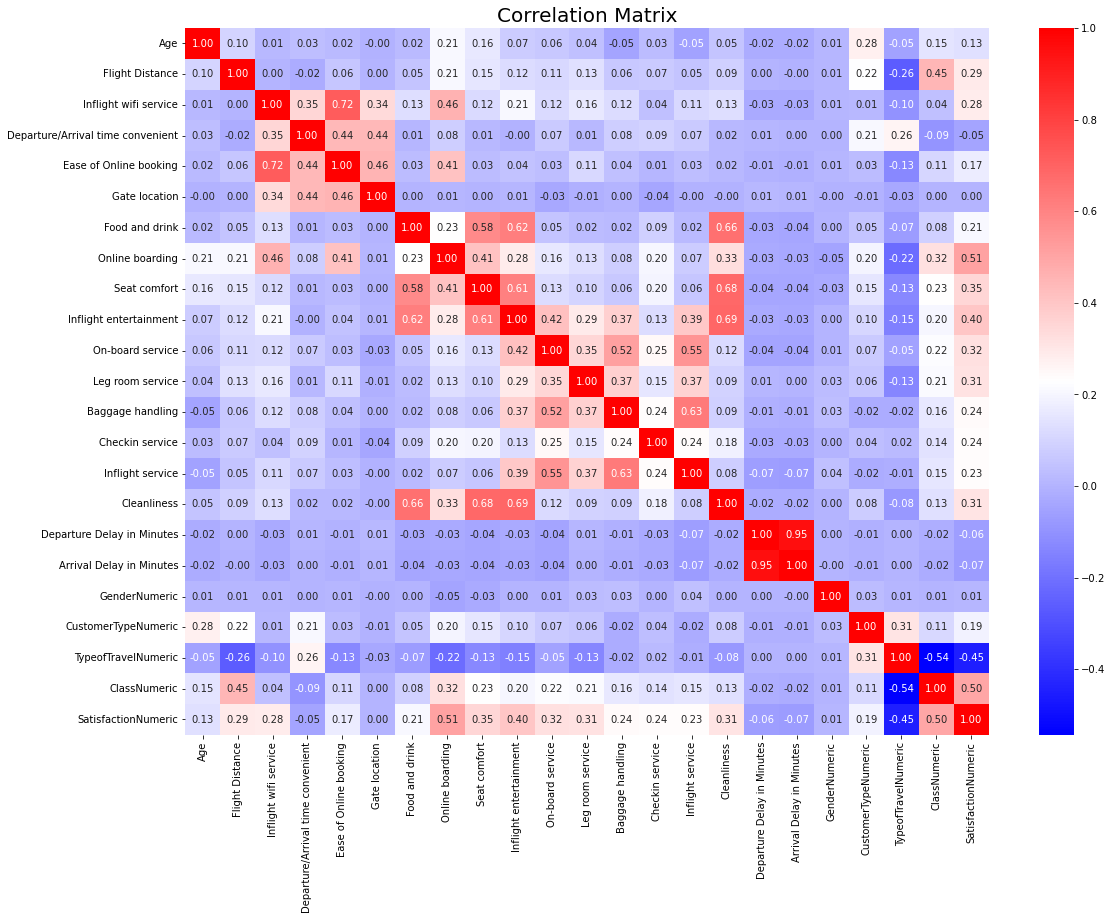

In [83]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(dfclean.corr(), annot=True, fmt=".2f", ax=ax, cmap="bwr")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

Very strong correlations (values from 0.8 to 1 or -0.8 to -1.0)
Strong correlations (values from 0.6 to 0.8 or -0.6 to -0.8)
Moderate correlations (values from 0.4 to 0.6 or -0.4 to -0.6) 

#### Check distribution of the data

C:\Users\thud1\anaconda3\envs\ML7331\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



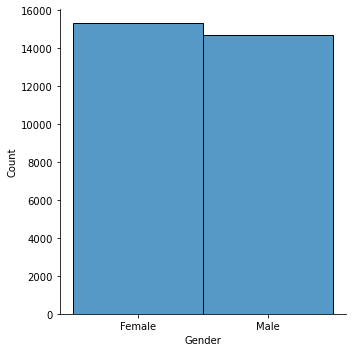

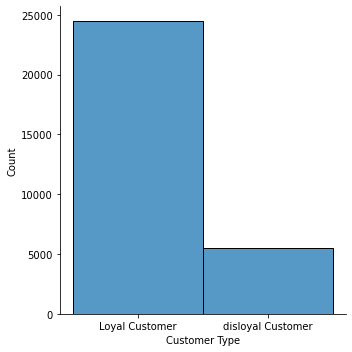

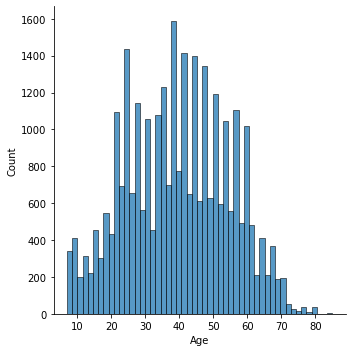

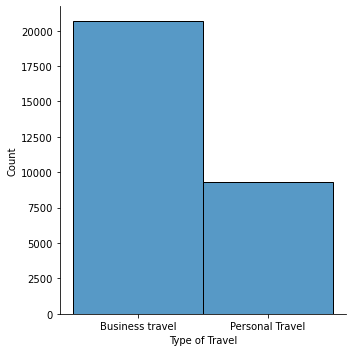

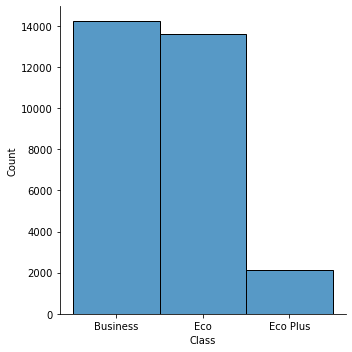

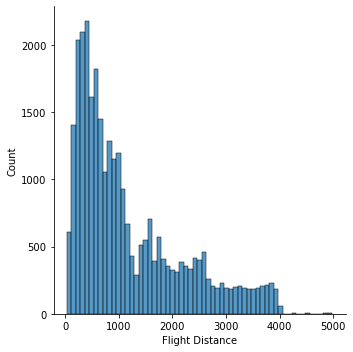

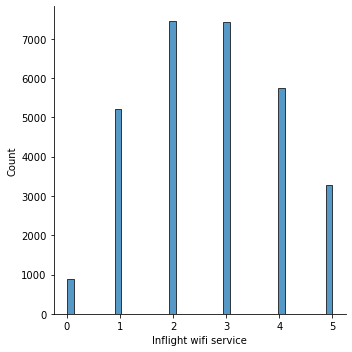

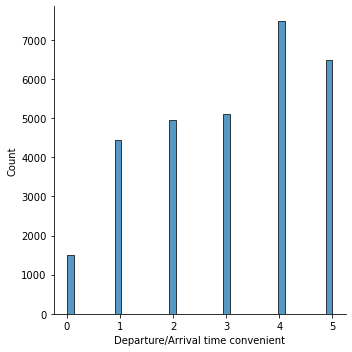

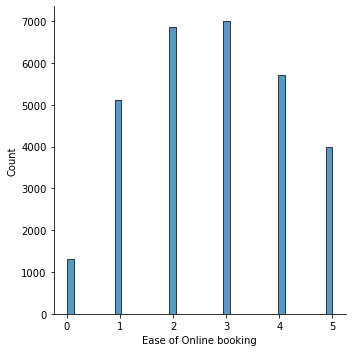

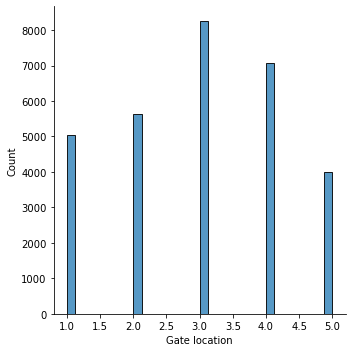

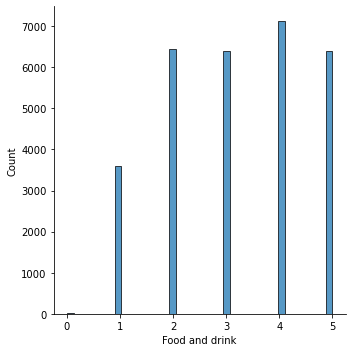

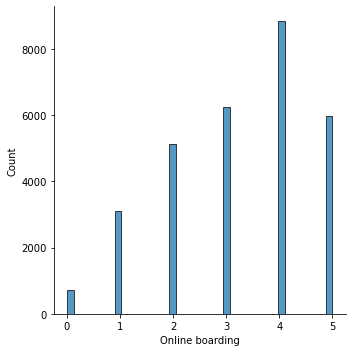

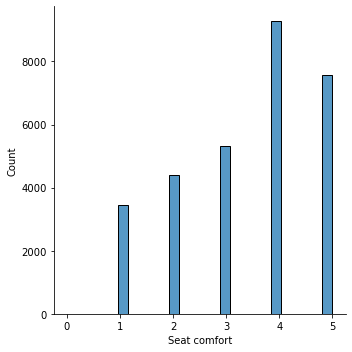

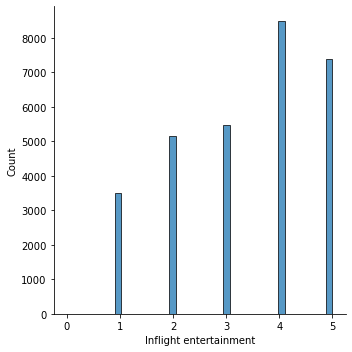

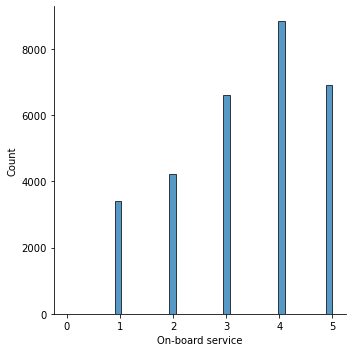

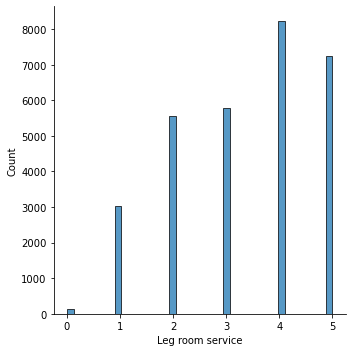

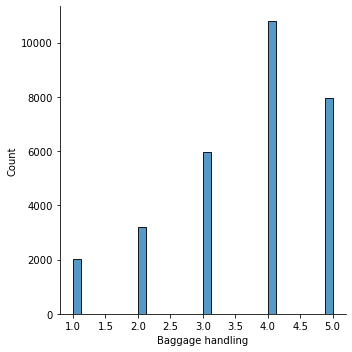

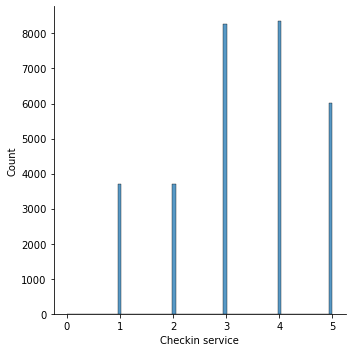

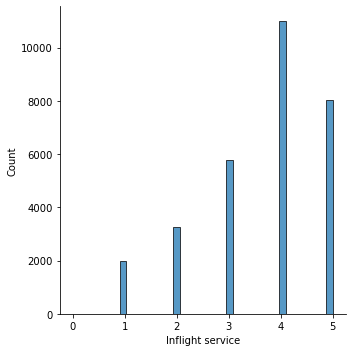

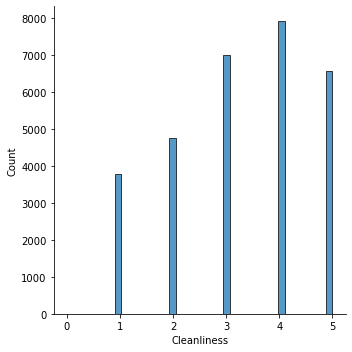

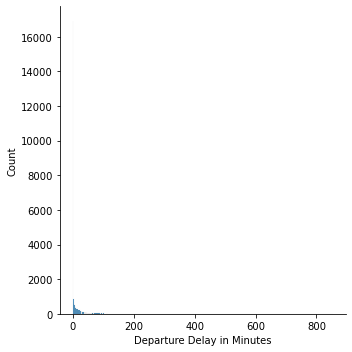

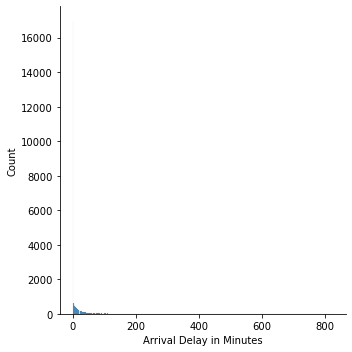

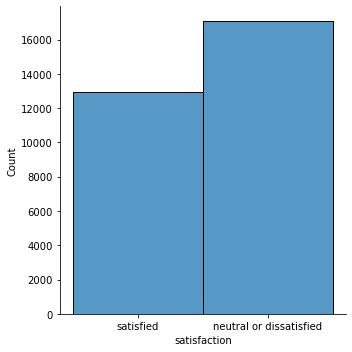

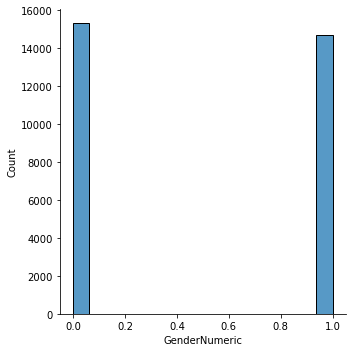

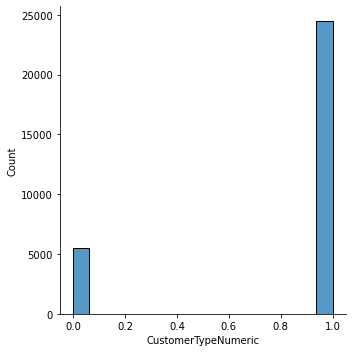

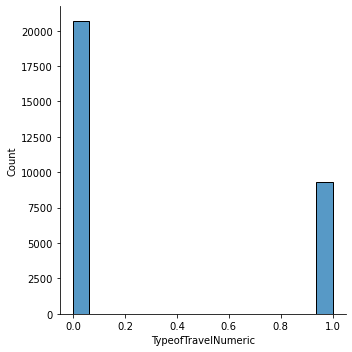

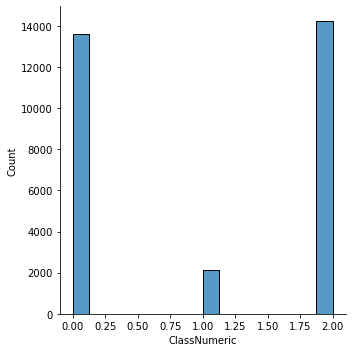

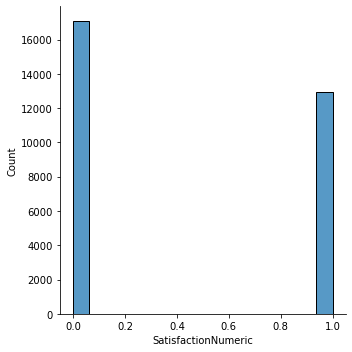

In [84]:
##distribution of the data

for column in dfclean:
    
    sns.displot(x=column, data=dfclean)

In [85]:
print (dfclean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 72611 to 31045
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             30000 non-null  object 
 1   Customer Type                      30000 non-null  object 
 2   Age                                30000 non-null  int64  
 3   Type of Travel                     30000 non-null  object 
 4   Class                              30000 non-null  object 
 5   Flight Distance                    30000 non-null  int64  
 6   Inflight wifi service              30000 non-null  int64  
 7   Departure/Arrival time convenient  30000 non-null  int64  
 8   Ease of Online booking             30000 non-null  int64  
 9   Gate location                      30000 non-null  int64  
 10  Food and drink                     30000 non-null  int64  
 11  Online boarding                    30000 non-null 

#### Summary of values to be used in classification modeling
A total of +100,000 passenger results are recorded in this data set.
We have a combination of categorical, ordinal and continous variable in this dataset.

- __Gender:__- Gender of the passengers (Female, Male) - Categorical Variable
- __Customer Type:__- The customer type (Loyal customer, disloyal customer) - Categorical Variable
- __Age:__- The actual age of the passengers - Continous Variable
- __Type of Travel:__- Purpose of the flight of the passengers (Personal Travel, Business Travel) - Categorical Variable
- __Class:__- Travel class in the plane of the passengers (Business, Eco, Eco Plus) - Categorical Variable
- __Flight distance:__- The flight distance of this journey - Continous Variable
- __Inflight wifi service:__- Satisfaction level of the inflight wifi service (0:Not Applicable;1-5) - Categorical Variable
- __Departure/Arrival time convenient:__- Satisfaction level of Departure/Arrival time convenient - Categorical Variable
- __Ease of Online booking:__- Satisfaction level of online booking - Categorical Variable
- __Gate location:__- Satisfaction level of Gate location - Categorical Variable
- __Food and drink:__- Satisfaction level of Food and drink - Categorical Variable
- __Online boarding:__- Satisfaction level of online boarding - Categorical Variable
- __Seat comfort:__- Satisfaction level of Seat comfort - Categorical Variable
- __Inflight entertainment:__- Satisfaction level of inflight entertainment - Categorical Variable
- __On-board service:__- Satisfaction level of On-board service - Categorical Variable
- __Leg room service:__- Satisfaction level of Leg room service - Categorical Variable
- __Baggage handling:__- Satisfaction level of baggage handling - Categorical Variable
- __Check-in service:__- Satisfaction level of Check-in service - Categorical Variable
- __Inflight service:__- Satisfaction level of inflight service - Categorical Variable
- __Cleanliness:__- Satisfaction level of Cleanliness - Categorical Variable
- __Departure Delay in Minutes:__- Minutes delayed when departure - Continous Variable
- __Arrival Delay in Minutes:__- Minutes delayed when Arrival - Continous Variable
- __Satisfaction:__- Airline satisfaction level(Satisfaction, neutral or dissatisfaction) - Categorical Variable

*** 
### [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

In [86]:
 #Sum Survey Score Columns - index(6:19)
dfclean['Survey_Total']=dfclean.iloc[:,6:19].sum(axis=1)

#Add Age Groups
dfclean['Age_Group'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["Adolescent", "Young Adult", "Middle Age", "Senior"], right=True)
dfclean['Age_Group_Numeric'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["1", "2", "3", "4"], right=True)

#Add Distance Groups
dfclean['Distance_Group'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["Short", "Moderate", "Long", "Extra Long"], right=True)
dfclean['Distance_Group_Numeric'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["1", "2", "3", "4"], right=True)

#Add Departure Delay Groups
dfclean['Departure_Delay_Group'] = pd.cut(dfclean['Departure Delay in Minutes'], bins = [-1,1,100,1600], labels=["None","Minimal","Long"], right=True)
dfclean['Departure_Delay_Group_Numeric'] = pd.cut(dfclean['Departure Delay in Minutes'], bins = [-1,1,100,1600], labels=["0","1","2"], right=True)




dfclean.head(n=50)

Gender      Customer Type  Age   Type of Travel     Class  \
72611   Female     Loyal Customer   28  Business travel  Business   
83635     Male     Loyal Customer   62  Personal Travel       Eco   
43812     Male     Loyal Customer   13  Personal Travel       Eco   
54594   Female  disloyal Customer   23  Business travel       Eco   
19418     Male     Loyal Customer    8  Personal Travel  Business   
18712     Male     Loyal Customer   40  Business travel  Business   
45309   Female     Loyal Customer   56  Business travel  Business   
77119     Male     Loyal Customer   53  Business travel  Business   
96438   Female     Loyal Customer   70  Personal Travel       Eco   
94182   Female     Loyal Customer   39  Business travel  Business   
73941     Male  disloyal Customer   36  Business travel       Eco   
99062   Female  disloyal Customer   37  Business travel       Eco   
26202   Female     Loyal Customer   46  Business travel  Business   
95116     Male     Loyal Customer   47  Business travel  Business   
9317    Female     Loyal Customer   16  Personal Travel       Eco   
61214   Female     Loyal Customer   58  Business travel  Business   
90424   Female     Loyal Customer   58  Business travel  Business   
1265    Female     Loyal Customer   50  Personal Travel       Eco   
51099   Female  disloyal Customer   36  Business travel  Business   
67202     Male     Loyal Customer   69  Personal Travel       Eco   
26271   Female     Loyal Customer   40  Business travel  Business   
61270     Male     Loyal Customer   40  Personal Travel       Eco   
98032   Female  disloyal Customer   44  Business travel  Business   
43873   Female     Loyal Customer   32  Business travel  Business   
87236     Male     Loyal Customer   28  Business travel       Eco   
102167    Male     Loyal Customer   65  Personal Travel       Eco   
85768   Female     Loyal Customer   37  Business travel  Business   
80644     Male     Loyal Customer   59  Personal Travel       Eco   
84298   Female     Loyal Customer   69  Personal Travel  Eco Plus   
7621    Female     Loyal Customer   38  Business travel  Business   
32283   Female     Loyal Customer   53  Business travel  Business   
18296   Female     Loyal Customer   33  Business travel  Business   
46999   Female     Loyal Customer   48  Business travel  Business   
40112     Male  disloyal Customer   23  Business travel       Eco   
35265     Male  disloyal Customer   28  Business travel       Eco   
34346   Female  disloyal Customer   23  Business travel       Eco   
61823   Female     Loyal Customer   56  Business travel  Business   
30736   Female     Loyal Customer   40  Personal Travel       Eco   
66325     Male     Loyal Customer   10  Personal Travel       Eco   
66378   Female     Loyal Customer   34  Personal Travel       Eco   
87605   Female     Loyal Customer   57  Personal Travel  Business   
89326     Male     Loyal Customer   26  Personal Travel       Eco   
61838   Female  disloyal Customer   20  Business travel       Eco   
101921    Male     Loyal Customer   28  Business travel  Business   
13216   Female     Loyal Customer   19  Personal Travel       Eco   
13646     Male     Loyal Customer   48  Business travel       Eco   
61492   Female     Loyal Customer   16  Personal Travel       Eco   
62738   Female     Loyal Customer   46  Personal Travel  Business   
33240     Male     Loyal Customer   35  Business travel  Business   
78674     Male  disloyal Customer   25  Business travel       Eco   

        Flight Distance  Inflight wifi service  \
72611              1846                      3   
83635               145                      1   
43812               226                      5   
54594               325                      0   
19418               529                      3   
18712              3173                      2   
45309               421                      1   
77119              1660                      2   
96438               372               

In [87]:
#Plotly Histogram - Age
px.histogram(dfclean['Age'], x= "Age",
             title = 'Age Distribution',
             )

In [88]:
#Plotly Histogram - Flight Distance
px.histogram(dfclean['Flight Distance'], x= "Flight Distance",
             title = 'Flight Distance Distribution',
             )

In [89]:
#Plotly Histogram - Departure Delay in Minutes
px.histogram(dfclean['Departure Delay in Minutes'], x= "Departure Delay in Minutes",
             title = 'Departure Delay Distribution',
             nbins = 50,
             )

In [90]:
#Plotly Histogram - Arrival Delay in Minutes
px.histogram(dfclean['Arrival Delay in Minutes'], x= "Arrival Delay in Minutes",
             title = 'Arrival Delay Distribution',
             nbins = 50,
             )

In [91]:
px.box(dfclean,
       x="Class", y="Age", 
       color="Class",
       title = "Box Plot of Age by Class")

In [92]:
#ANOVA of class to age
# Ordinary Least Squares (OLS) model
model = ols('Age ~ C(Class)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df           F         PR(>F)
C(Class)  1.439619e+05      2.0  325.285907  1.738815e-140
Residual  6.637892e+06  29997.0         NaN            NaN

The ANOVA between age and class shows overwhelming evidence that there is a difference between the mean age of travelers among the various classes.

In [93]:
px.box(dfclean,
       x="Class", y="Survey_Total", 
       color="Class",
       title = "Box Plot of Survey Total by Class")

In [94]:
#ANOVA of Class to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Class)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df            F  PR(>F)
C(Class)  1.668811e+05      2.0  1239.185819     0.0
Residual  2.019848e+06  29997.0          NaN     NaN

The ANOVA between class and survey score shows overwhelming evidence that there is a difference between the mean survey score among the classes.

In [95]:
px.box(dfclean,
       x="Distance_Group", y="Survey_Total", 
       color="Distance_Group",
       title = "Box Plot of Distance Traveled by Survey Total")

In [96]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Distance_Group)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df           F         PR(>F)
C(Distance_Group)  4.344885e+04      3.0  202.694268  3.692897e-130
Residual           2.143280e+06  29996.0         NaN            NaN

The ANOVA between distance group and survey score shows overwhelming evidence that there is a difference between the mean survey score among the distance groups.

In [97]:
#ANOVA of class to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Age)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df          F         PR(>F)
C(Age)    6.459027e+04     74.0  12.308234  7.734038e-142
Residual  2.122139e+06  29925.0        NaN            NaN

In [98]:
px.box(dfclean,
       x="Departure_Delay_Group", y="Survey_Total", 
       color="Departure_Delay_Group",
       title = "Box Plot of Total by Departure Delay Group")

In [99]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Departure_Delay_Group)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df          F        PR(>F)
C(Departure_Delay_Group)  2.088604e+03      2.0  14.339169  5.964212e-07
Residual                  2.184640e+06  29997.0        NaN           NaN

The ANOVA between departure delay group and survey score shows overwhelming evidence that there is a difference between the mean survey score among the distance groups.

In [100]:
#2 Sample T-Test - Male vs Female

# Subset data
male = dfclean.query('Gender == "Male"')['Survey_Total']
female = dfclean.query('Gender == "Female"')['Survey_Total']

dfclean.groupby('Gender').describe()

Age                                                     \
          count       mean        std  min   25%   50%   75%   max   
Gender                                                               
Female  15309.0  39.238291  15.128763  7.0  27.0  39.0  51.0  85.0   
Male    14691.0  39.464706  14.937543  7.0  27.5  40.0  51.0  85.0   

       Flight Distance               ... SatisfactionNumeric       \
                 count         mean  ...                 75%  max   
Gender                               ...                            
Female         15309.0  1181.890914  ...                 1.0  1.0   
Male           14691.0  1196.271255  ...                 1.0  1.0   

       Survey_Total                                                     
              count       mean       std   min   25%   50%   75%   max  
Gender                                                                  
Female      15309.0  42.094389  8.634133  14.0  36.0  42.0  48.0  65.0  
Male        14691.0  42.196379  8.436147  14.0  36.0  42.0  48.0  65.0  

[2 rows x 192 columns]

In [101]:
#Check normality assumption

#Plotly Histogram - Total
px.histogram(dfclean, x= "Survey_Total",
             title = 'Survey Total Distribution',
             facet_col="Gender"
             )

In [102]:
#Check Variance Assumptions
stats.levene(male, female)

LeveneResult(statistic=9.543701250909772, pvalue=0.002008201263013134)

In [103]:
#T-Test
res = stats.ttest_ind(male, female, equal_var=True)

display(res)

Ttest_indResult(statistic=1.0343122551632213, pvalue=0.30099854743336485)

***
### Modeling and Evaluation (50 points total) Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. 



#### Option A: Cluster Analysis
- Perform cluster analysis using several clustering methods
- How did you determine a suitable number of clusters for each method?
- Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
- Describe your results. What findings are the most interesting and why?

### KNN Clustering with PCA

In [104]:
#set data to be ready for cluster analysis
cluster_df = dfclean.copy()

continuous_features = ['Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes']

# and the oridnal values to be integers
ordinal_features = ['Age','Inflight wifi service','Departure/Arrival time convenient']

# we won't touch these variables, keep them as categorical
categ_features = ['GenderNumeric','TypeofTravelNumeric','CustomerTypeNumeric', 'SatisfactionNumeric'];

# use the "astype" function to change the variable type
cluster_df[continuous_features] = cluster_df[continuous_features].astype(np.float64)
cluster_df[ordinal_features] = cluster_df[ordinal_features].astype(np.int64)
cluster_df = cluster_df.drop(['Age_Group','Distance_Group','Distance_Group_Numeric','Gender','Customer Type','Type of Travel', 'Class','Departure_Delay_Group','Departure_Delay_Group_Numeric','Age_Group_Numeric', 'satisfaction'], axis=1)


cluster_df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 72611 to 31045
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                30000 non-null  int64  
 1   Flight Distance                    30000 non-null  float64
 2   Inflight wifi service              30000 non-null  int64  
 3   Departure/Arrival time convenient  30000 non-null  int64  
 4   Ease of Online booking             30000 non-null  int64  
 5   Gate location                      30000 non-null  int64  
 6   Food and drink                     30000 non-null  int64  
 7   Online boarding                    30000 non-null  int64  
 8   Seat comfort                       30000 non-null  int64  
 9   Inflight entertainment             30000 non-null  int64  
 10  On-board service                   30000 non-null  int64  
 11  Leg room service                   30000 non-null 

In [105]:
#scale values
cluster_df_scaled = StandardScaler().fit(cluster_df).transform(cluster_df.astype(float))

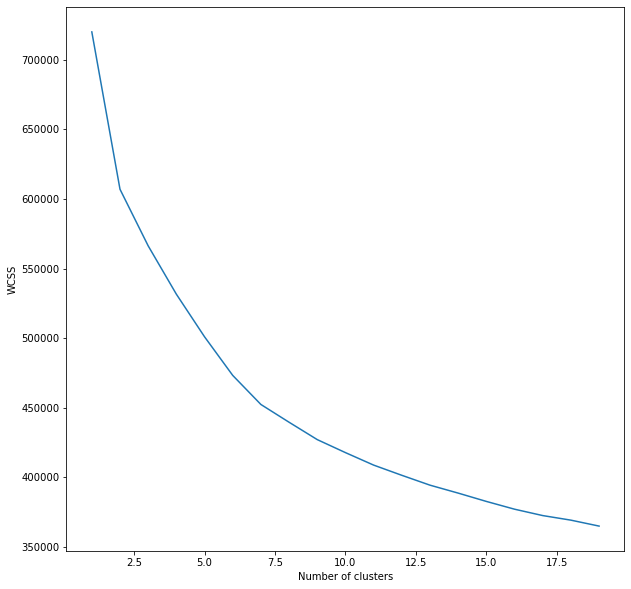

In [106]:
# finding optimal cluster amount
wcss = []
for i in range(1,20):
   model = KMeans(n_clusters = i, init = "k-means++", random_state=50)
   model.fit(cluster_df_scaled)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,20), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

##### WCSS summary
Based on the WCSS curve, we see the it stars to shallow around 7.5.  To ensure that we do not over fit our clustering models we will use 8 as the clusters for our PCA components.  Any more may impact the models performance.

##### PCA used to reduce dimensionality
Utilizing PCA, we selected 2 PCA components to allow for easier interpretation and visualization of the clusters.

In [107]:
# reducing dimensionality to 
pca = PCA(2)
data = pca.fit_transform(cluster_df_scaled)
data

array([[-1.46422726,  0.03918117],
       [ 2.06231167,  1.72760141],
       [-1.26279049, -2.80573081],
       ...,
       [-4.0033047 , -0.62870279],
       [ 0.16393576, -0.14667488],
       [ 0.09333501,  0.3144797 ]])

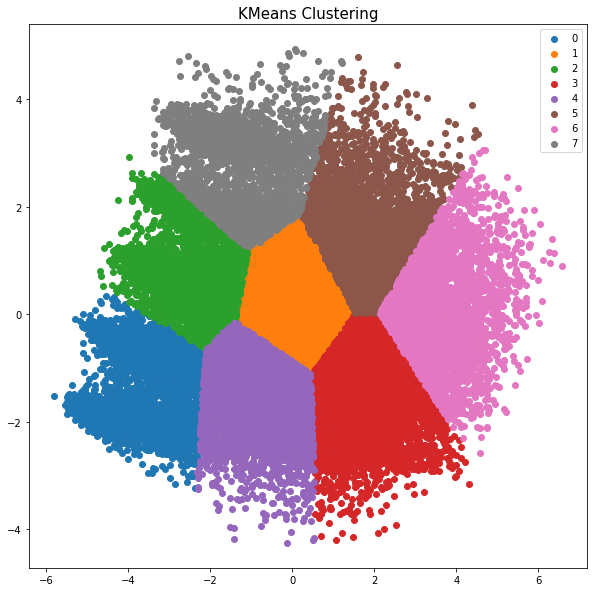

In [108]:
# clustering with PCA components

model = KMeans(n_clusters = 8, init = "k-means++")
label = model.fit_predict(data)


plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('KMeans Clustering', fontsize=15)
plt.show()

In [111]:
metrics.silhouette_score(cluster_df_scaled, label)

0.044469440137103564

#### Intepretation of Silhouette score of KNN Clustering
We use the Silhouette score to measure how dense and well-separated the clusters are for our data set.
The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
In this instance we have a Silhouette score 0.05121.  Since its not negative and the visual show distinct clustering we fill that our PCA scaled cluster is adequate.

### DBSCAN Clustering

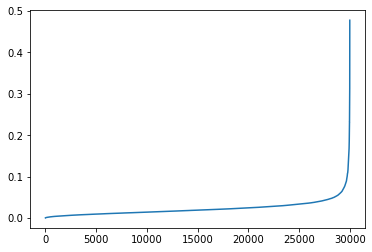

In [124]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

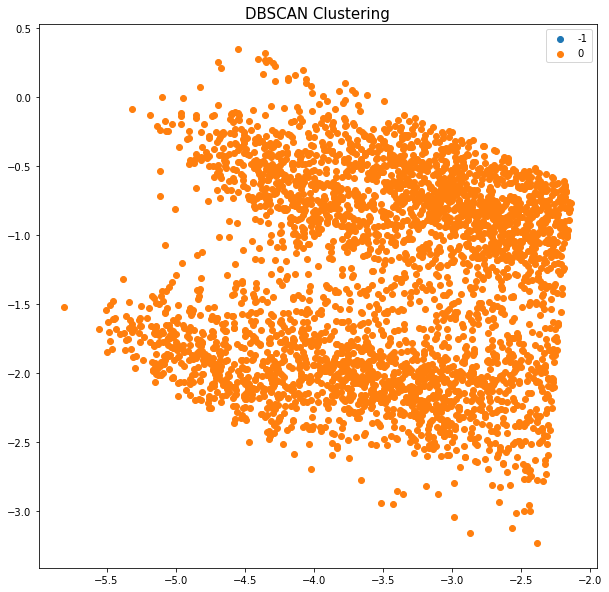

In [133]:
# DBScan Clustering with PCA

dbscan = DBSCAN(eps=0.4)
dbscan_label = dbscan.fit_predict(data)

plt.figure(figsize=(10,10))
uniq = np.unique(dbscan_label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('DBSCAN Clustering', fontsize=15)
plt.show()

In [134]:
metrics.silhouette_score(cluster_df_scaled, dbscan_label)

0.4021846714521469

#### Intepretation of Silhouette score of DBScan Clustering
In the Dbscan instance we have a Silhouette score 0.1639.  However we did not observe dense clustering and this method will not be selected.

#### Hierarchical Agglomerative Clustering (HAC) Clustering

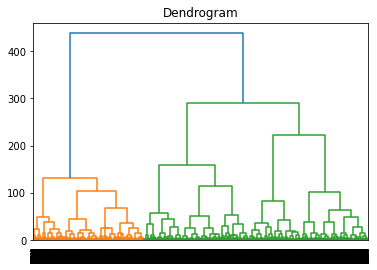

In [41]:
# utilizing a dendrogram to find the optimal number of clusters

dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
plt.title('Dendrogram')
plt.show()

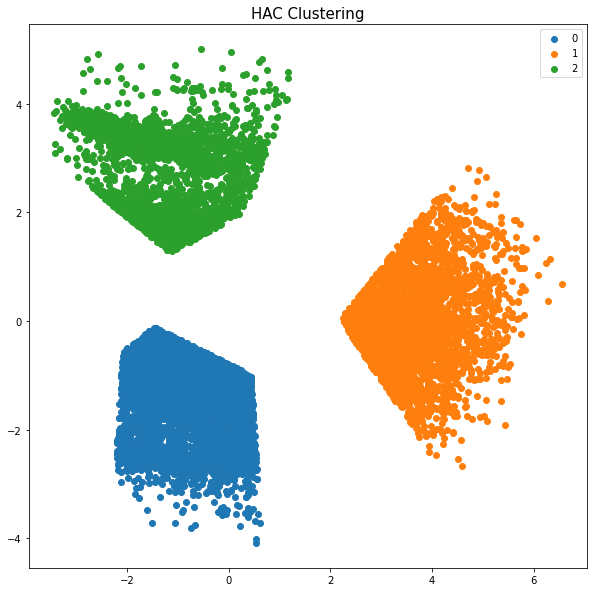

In [42]:
hac = AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward')
hac_label = hac.fit_predict(data)

plt.figure(figsize=(10,10))
uniq = np.unique(hac_label)
for i in uniq:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('HAC Clustering', fontsize=15)
plt.show()

In [43]:
metrics.silhouette_score(cluster_df_scaled, hac_label)

0.09787416090426526

#### Intepretation of Silhouette score of HAC Clustering
In the HAC instance we have a Silhouette score 0.1639.  However we did not observe dense clustering and this method will not be selected.

In [44]:
result_df = dfclean.copy()
result_df['kmeans_cluster'] = label
result_df['dbscan_cluster'] = dbscan_label
result_df['hac_cluster'] = hac_label
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 4544 to 40731
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             30000 non-null  object  
 1   Customer Type                      30000 non-null  object  
 2   Age                                30000 non-null  int64   
 3   Type of Travel                     30000 non-null  object  
 4   Class                              30000 non-null  object  
 5   Flight Distance                    30000 non-null  int64   
 6   Inflight wifi service              30000 non-null  int64   
 7   Departure/Arrival time convenient  30000 non-null  int64   
 8   Ease of Online booking             30000 non-null  int64   
 9   Gate location                      30000 non-null  int64   
 10  Food and drink                     30000 non-null  int64   
 11  Online boarding                    300

Text(0.5, 1.0, 'HAC')

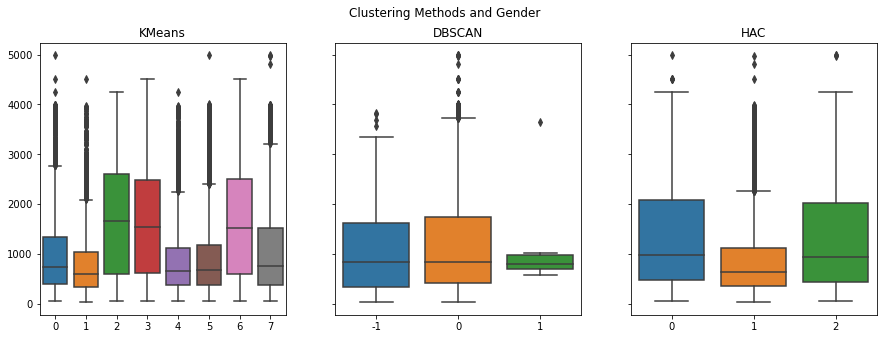

In [45]:
# clusters compared to Gender
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Clustering Methods and Gender')

# Kmeans
sns.boxplot(ax=axes[0], x=result_df['kmeans_cluster'].values, y=result_df['Flight Distance'].values)
axes[0].set_title('KMeans')

# DBSCAN
sns.boxplot(ax=axes[1], x=result_df['dbscan_cluster'].values, y=result_df['Flight Distance'].values)
axes[1].set_title('DBSCAN')

# HAC
sns.boxplot(ax=axes[2], x=result_df['hac_cluster'].values, y=result_df['Flight Distance'].values)
axes[2].set_title('HAC')


Text(0.5, 1.0, 'HAC')

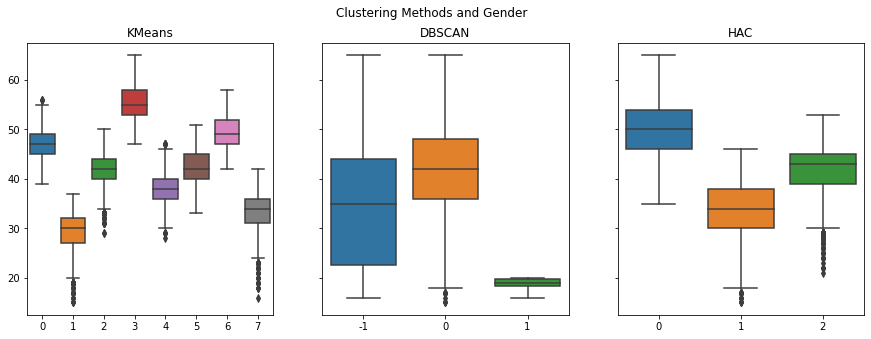

In [46]:
# clusters compared to Survey Total
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Clustering Methods and Gender')

# Kmeans
sns.boxplot(ax=axes[0], x=result_df['kmeans_cluster'].values, y=result_df['Survey_Total'].values)
axes[0].set_title('KMeans')

# DBSCAN
sns.boxplot(ax=axes[1], x=result_df['dbscan_cluster'].values, y=result_df['Survey_Total'].values)
axes[1].set_title('DBSCAN')

# HAC
sns.boxplot(ax=axes[2], x=result_df['hac_cluster'].values, y=result_df['Survey_Total'].values)
axes[2].set_title('HAC')


### ACTION REQUIRED
Need to add intrepretation 

### Deployment (10 points total)
- Be critical of your performance and tell the reader how you current model might be usable by
other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
- How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.?

#### Deployment Summary
All models proved effective at creating clearly defined groups that customers could then extropolate back to the original data to find unclear relationships between the features of interest, which was our goal

This type of model is useful because we are able to take a data driven approach to generate behavioral benchmarks to how one responds to their satisfaction to the airline.  We identified this in our model and this model has the ability to identify actual dissatisfaction or potential anomalies.

Deployment of this method can be done be sharing this code to interested airline companies.  We will be required to refactor the data on the company's record.  In addition, we can provide airline companies to incorporate survey requirements to ensure that the model captures the relevant needs to the model

Other additional data that we may think will impact the data set
	• Age of aircraft or last remodel - Functionality on the aircraft in today's environment may impact customer view of the airline.
	• Weather condition during the flight - Depending on the conditions of the flight, we may have encountered turbulent weather that is out of the airlines control that we could identify as anomalies that may have skewed the customer satisfaction

The cadence of these reports should coincide to quarterly financial reports as this can be utilized to assess and course correct any issues to the financial plan as low customer satisfaction impacts both top and bottom line of the P&L.

### Exceptional Work (10 points total)
You have free reign to provide additional analyses or combine analyses

### Gausian Mixture

In [47]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [50]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 4544 to 40731
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                30000 non-null  int64  
 1   Flight Distance                    30000 non-null  float64
 2   Inflight wifi service              30000 non-null  int64  
 3   Departure/Arrival time convenient  30000 non-null  int64  
 4   Ease of Online booking             30000 non-null  int64  
 5   Gate location                      30000 non-null  int64  
 6   Food and drink                     30000 non-null  int64  
 7   Online boarding                    30000 non-null  int64  
 8   Seat comfort                       30000 non-null  int64  
 9   Inflight entertainment             30000 non-null  int64  
 10  On-board service                   30000 non-null  int64  
 11  Leg room service                   30000 non-null  

In [51]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(cluster_df) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df)

###GMM AIC and BIC Testing on Normalized Data

In [52]:
n_range = range(2,20)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(normalized_df)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(normalized_df))
    aic_score.append(gm.aic(normalized_df))

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

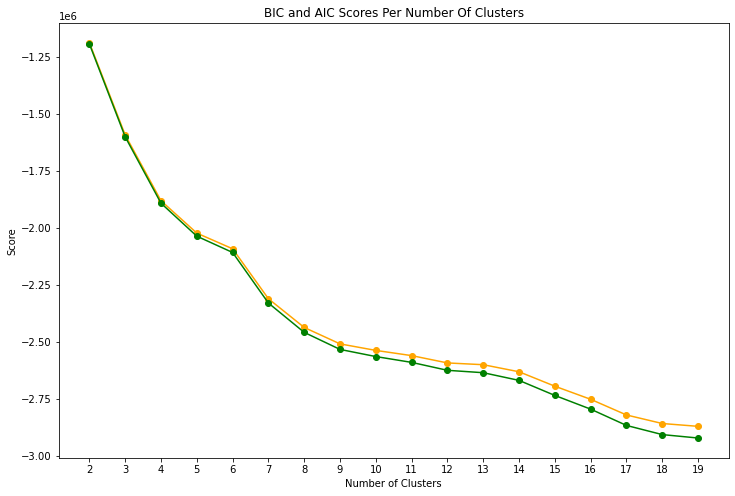

In [53]:
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In this AIC/BIC plot we can look to see the best prediction model has we increase the numbers of clusters. One of the more concerning aspect of this particular AIC/BIC graph is the amount of clusters required to optimize the model. We see a decrease at 4/5 clusters, however we see a continuous decrease in the scores. This makes it a challenge to have a definitive chose of clusters.

In order to potentially help the gaussian mixture model to better help fit the dataset, utilizing PCA feature reduction will be necessary.

In [54]:
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

gmm = GaussianMixture(n_components = 3) 
gmm.fit(X_principal)

GaussianMixture(n_components=3)

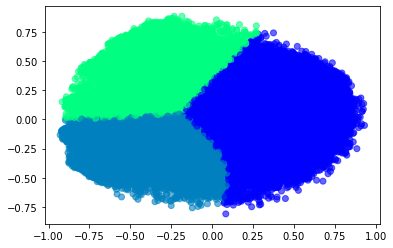

In [55]:
# Visualizing the clustering 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = GaussianMixture(n_components = 3).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 
plt.show() 

In [56]:
n_range = range(2,11)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(X_principal)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(X_principal))
    aic_score.append(gm.aic(X_principal))

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

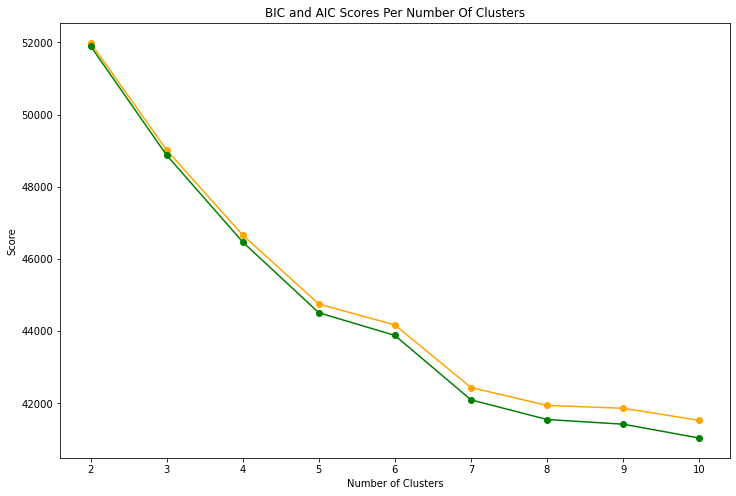

In [57]:
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In this AIC/BIC cluster comparison graph we can see a large decrease in error at 3 clusters. This makes sense looking at the PCA graph. We do see a continuous improvement as the number of clusters are increased. However, when looking at the PCA graph is easy to see the 3 clusters that form, so we should be careful with using more than 3 clusters as it may lead to over-fitting.

Using PCA for feature reduction significantly helped reduce the number of required clusters and more quickly improved the AIC/BIC error scores. This also lead to the additional side effect of reducing the computational power to find the ideal number of clusters to fit the dataset.

Conclusion
The Gaussian Mixture Model appears to a good choice for this particular dataset. There are some limitations to this process however, the data needed to use PCA feature reduction to preform well. Without PCA, the model struggled to significantly reduce the AIC/BIC scores as clusters increased. This also made it more challenging to decide on how much clusters should utilized. While this model was able to have good results, less complicated models may to prove to be just as useful under similar conditions.